<h1><center>Bayesian Computation project, Spring 2019</center></h1>
<center>Charles Dufour, Sciper: 257587</center>


#### Table of content
1. [Dataset exploration and loading](#data)

2. [Modelizations](#plan)





3. [Gaussian noise and gaussian prior](#model1)
    - [Metropolis Hasting](#MH1)
    - [Importance sampling](#IS1)
    - [Gaussian variationnal approximation](#GVA1)
    
    
    
4. [Student noise and gaussian prior](#model2)
    - [Metropolis Hasting](#MH2)
    - [Importance sampling](#IS2)
    - [Gaussian variationnal approximation](#GVA2)
    
    
    
    
    
    
5. [Gaussian noise and spike-slab prior](#model3)
    - [Metropolis Hasting](#MH3)
    - [Importance sampling](#IS3)
    - [Gaussian variationnal approximation](#GVA3)
    
    
    
    
    
6. [Classification (trial)](#classification)

[Todos](#todo)

In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
sns.set()

import scipy.stats as scp
from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from scipy.stats import t as student
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import poisson
from scipy.stats import bernoulli

from sklearn.model_selection import train_test_split

import src.optimization as opti
import src.sampling as sampling 
import src.helpers as Plot
from src.approximation import *

In [17]:
import src.sampling.Metropolis_Hastings as sampling 

In [19]:
sampling.f(2)

[1 2 3]


In [12]:
def big_plot(a = 16.0,b = 8.0):
    plt.rcParams['figure.figsize'] = (a, b)

def reset_plot():
    plt.rcParams['figure.figsize'] = (8.0, 4.0)

<a id="data"></a>
# Wages in the USA dataset (May 1985) 
from _E. R. Berndt. The practice of econometrics : classic and contemporary. Addison-Wesley Pub. Co., 1991_

In [13]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors = df[['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF']]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
X, X_test, Y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
df.head()

,ED,SOUTH,NONWH,HISP,FE,MARR,MARRFE,EX,UNION,LNWAGE,MANUF,CONSTR,MANAG,SALES,CLER,SERV,PROF
0,-1.155307,0,0,0,0,1,0,0.742062,0,0.261776,0,1,0,0,0,0,0
1,-0.389880,0,0,0,0,1,0,0.176090,0,-0.672335,0,0,0,1,0,0,0
2,-0.389880,0,0,0,1,0,0,-1.117559,0,-1.373535,0,0,0,1,0,0,0
3,-0.389880,0,0,0,1,1,1,0.903768,0,0.554243,0,0,0,0,1,0,0
4,-0.389880,0,0,0,0,1,0,1.793152,1,1.230596,0,1,0,0,0,0,0


the salary have two outliers: 

In [15]:
max_index = np.where(df.LNWAGE.values == np.max(df.LNWAGE.values))[0]
min_index = np.where(df.LNWAGE.values == np.min(df.LNWAGE.values))[0]
print("salary: max {} \n        min {}".format(df.LNWAGE.values[max_index][0],df.LNWAGE.values[min_index][0]))

salary: max 3.2932279177934203 
        min -3.9055931964694404


<a id="plan"></a>

# Modelization

We will model as follows: $$ Y = X\beta + \epsilon$$

With:
- $\beta$ having prior $\mathcal{N}(\vec{0},\Sigma)$
- $\epsilon$ being the noise will be from the following distribution: gaussian or student

And:
- $\beta$ having a sparsity inducing prior, the spike slab prior:


- $\epsilon \sim \mathcal{N}(0,\sigma²)$  

<a id="model1"></a>

## 1. Gaussian noise and gaussian prior

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


Covariance matrix of $\boldsymbol{\beta} = 3^{2}Id_d$

In [52]:
def log_prior_beta(beta):
    spb = 3
    return np.log(multivariate_normal.pdf(beta, mean = np.repeat(0,len(beta)), cov = spb**2*np.eye(len(beta))))

In [53]:
def log_prior_sigma(sigma):
    return np.log(expon.pdf(sigma, scale = 1/2))

The prior is then:
$$f(\beta) = \frac{1}{3^d(2\pi)^{d/2}}\exp\left( -\frac{1}{2\cdot3^{2d}}||\beta||^2 \right)\quad \beta\in \mathcal{R}^d $$

The likelihood is then: 
$$f(y_1,\ldots,y_n|X,\beta) = \prod_{i=1}^{n}\frac{1}{\sigma} \varphi\left(\frac{y_i -x_i^T\beta}{\sigma}\right)$$

In [54]:
def log_likelihood(Y,X,beta,sigma):
    result = np.sum(np.log(norm.pdf((Y-X@beta)/sigma)))
    return result - len(Y)*np.log(sigma)

So the posterior will be:

$$\tilde f(\beta) = f(\beta)*f(\sigma)*L(y_1,\ldots,y_n|X,\beta) $$

And the normalization constant $f(y_1,\ldots,y_n) = \int f(y_1,\ldots,y_n|X,\beta)f(\beta|X)d\beta$  will be estimated using sampling methods

In [55]:
def log_posterior(beta,sigma,Y,X):
    return log_prior_beta(beta)+log_likelihood(Y,X,beta,sigma) + log_prior_sigma(sigma)

In [56]:
beta_OLS = np.linalg.inv(X.T@X)@X.T@Y
sigma_OLS = (Y-X@beta_OLS).T@(Y-X@beta_OLS)/(len(Y)-len(beta_OLS))

[ 0.3516061  -0.18565178 -0.20497786 -0.21370171 -0.23936866  0.16978968
 -0.16203394  0.25828846  0.38596224  0.21299635  0.14217309  0.39445595
 -0.29814104  0.02606267 -0.34522073  0.29805171]
0.6240345697108981


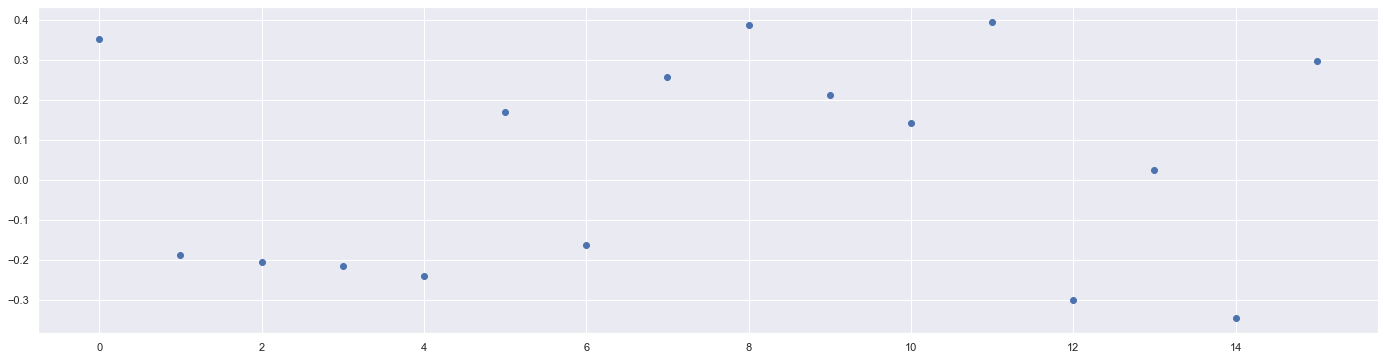

In [57]:
print(beta_OLS)
print(sigma_OLS)
plt.plot(beta_OLS,'o')
plt.show()

We have 15 possible covariates, normalized.  We will now compute the estimators of $\beta$ and its credible interval. 


We know use sampling techniques to determine the posterior distribution

## Sampling to estimate the posterior distribution

In [58]:
def log_posterior_simple(theta):
    sigma = theta[0]
    beta = theta[1:]
    return log_posterior(beta,sigma,Y,X)

In [59]:
theta = np.insert(beta_OLS,0,sigma_OLS)

<a id="MH1"></a>

### Metropolis Hastings algorithm

/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


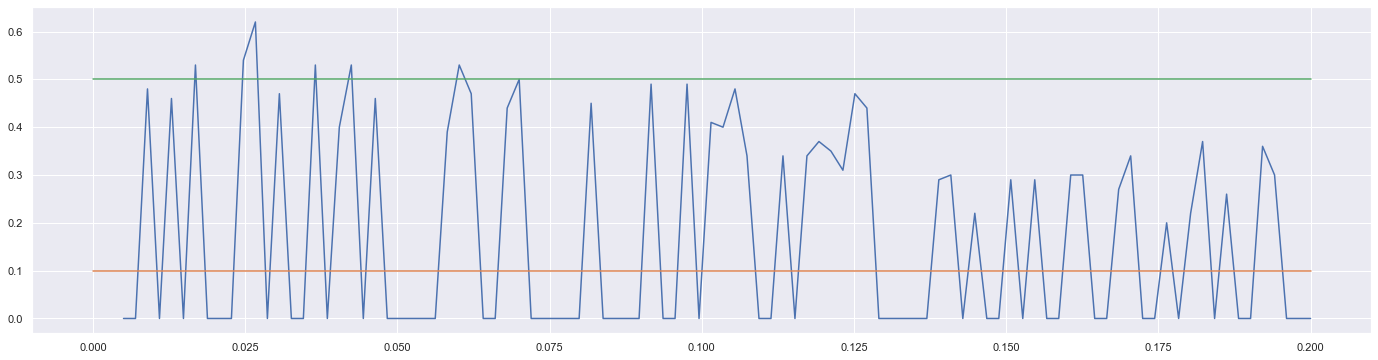

In [66]:
S = []
A = []
for s in np.linspace(0.005,0.2,100):
    samples, a = sampling.MH_sampling(log_posterior_simple,size = 17,max_iter= 100, step_size= s, acc = True, verbose=False, verbose_gen = False)
    S.append(s)
    A.append(a)
plt.plot(np.array(S), np.array(A))
plt.plot([0,0.2],[0.1,0.1])
plt.plot([0,0.2],[0.5,0.5])
plt.show()

In [84]:
with warnings.catch_warnings(record=True):
    samples_gaussian = sampling.MH_sampling(log_posterior_simple, max_iter = 20000 ,step_size = 0.045, size = 17, initial = theta)
#np.save("results/samples_gaussian_MH",samples_gaussian)

Metropolis Hasting started at: 2019-05-28 17:57:24
Simulating data : [====================] 99.98%   Acceptance rate : 16.8%  (advised values between 10% and 50%)
  duration: 0:00:25


iterations


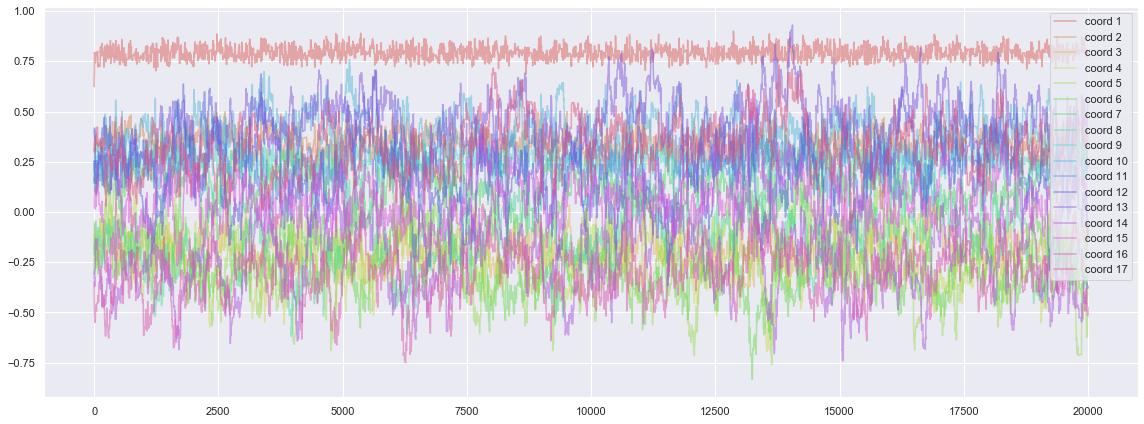

estimation of the distributions


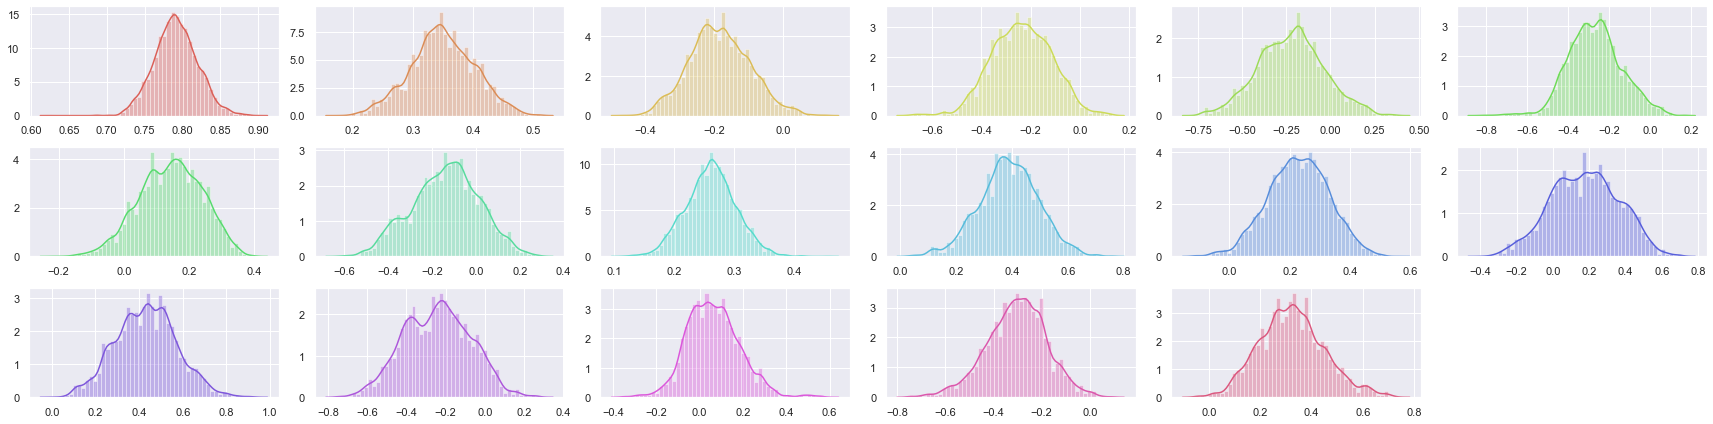

autocorrelation


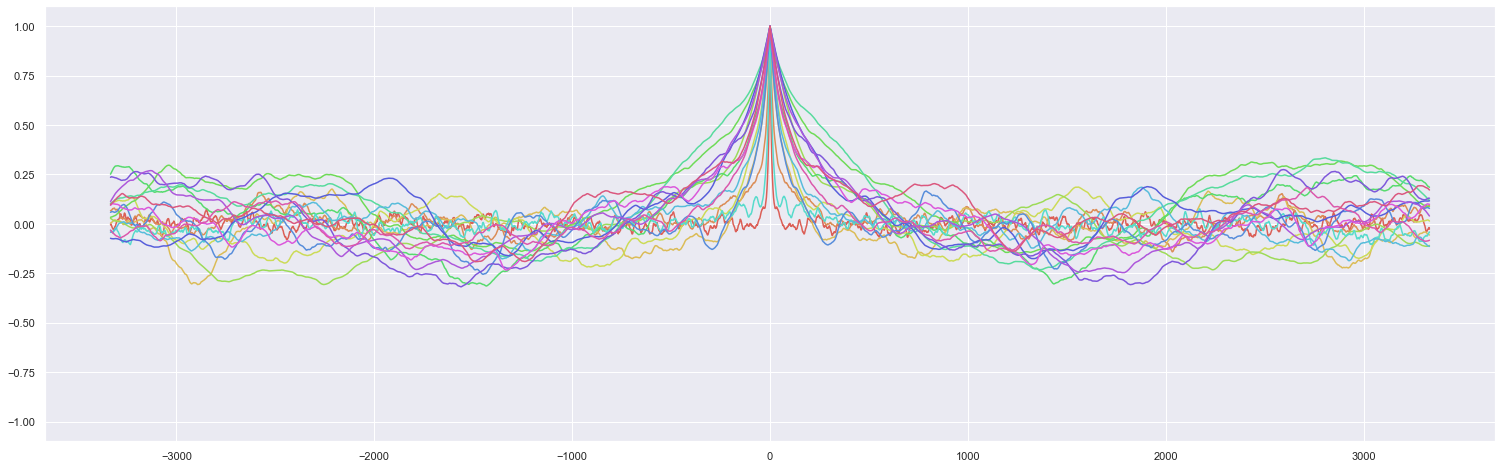

In [86]:
with warnings.catch_warnings(record=True):
    Plot.samples_exploration(samples_gaussian,distribution=True,correlation= True, size_samples = (16,6))

<a id="IS1"></a>

### Importance sampling

In [26]:
# proposal will be a gaussian N(0,5)
def proposal_generation(n):
    inter = []
    for i in range(n):
        inter.append(np.insert(np.random.normal(0,5,len(beta_OLS)),0,np.random.exponential(scale = 2)))
    return np.array(inter)

def proposal(theta):
    inter = multivariate_normal.pdf(theta[1:],cov = 5*np.eye(len(theta)-1))
    return inter + expon.pdf(theta[0],scale = 1/2)

def posterior_unormalized(theta):
    return np.exp(log_posterior_simple(theta))

In [27]:
samples, weight = sampling.importance_sampling(log_posterior_simple,proposal_generation,proposal,20000, separated= True)
#np.save("results/importance_samples_Gaussian",[samples,weight])

Simulating data : [==                  ] 9.2%  0.0 -4249.874013663907

/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Simulating data : [====================] 100% Done...
 0.0 -15718.625032060501 duration: 0:00:18


In [28]:
np.max(weight)

2.718281828459045

comparison

In [29]:
#[samples,weight] = np.load("results/importance_samples_Gaussian.npy")
#weighted_samples = samples*weight
samples_gaussian = np.load("results/samples_gaussian_MH.npy")

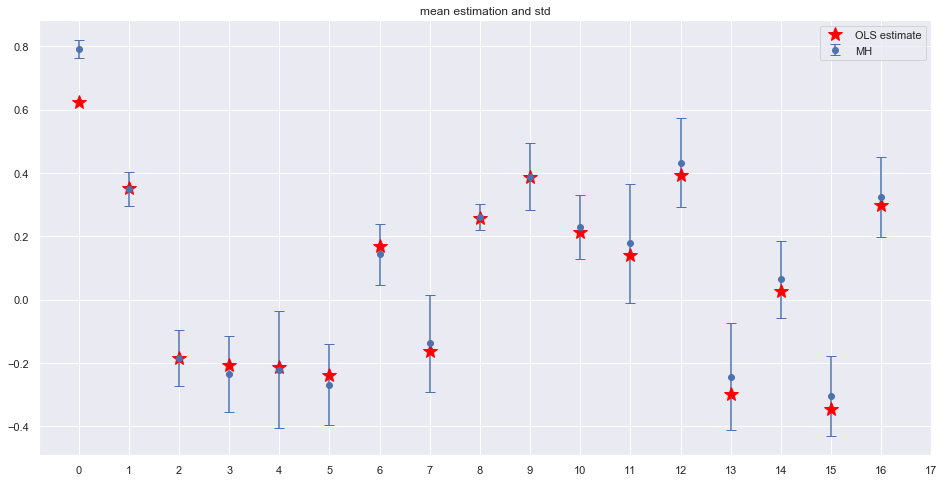

In [87]:
big_plot()
#plt.errorbar(np.arange(len(weighted_samples[0])), np.sum(weighted_samples,axis=0)/np.sum(weight), np.std(weighted_samples,axis = 0), linestyle='None',marker = "o", capsize=5, label = "importance sampling") 
plt.errorbar(np.arange(len(samples_gaussian[0])), np.mean(samples_gaussian,axis=0), np.std(samples_gaussian,axis = 0), linestyle='None',marker = "o", capsize=5, label = "MH") 
plt.plot(theta, label = "OLS estimate", marker = "*", linestyle = "None", color = "red", markersize = 15)
plt.xticks(np.arange(0,18,1),np.arange(0,18,1))
plt.legend()
plt.title("mean estimation and std")
plt.show()
reset_plot()

<a id="GVA1"></a>

### Gaussian variational approximation

We get,  with $\theta = [\sigma,\beta^T]\quad \beta \in \mathbb{R}^p$



$$\begin{align*}
\phi(\theta) &=-\log\left[\tilde{f}(\theta|d) \right] \\
& = \frac{1}{2\cdot 3^p}||\beta||^2 + 2\sigma + \frac{1}{2}\sum\limits_{i=1}^{n}\left(\frac{y_i -x_i^T\beta}{\sigma} \right)^2 + n\log(\sigma) + \left[p\log(3) + \frac{p}{2}\log(2\pi) - \log(2)+ \frac{n}{2}\log(2\pi) \right] \in \mathbb{R}
\end{align*}$$

Hence we compute the gradient:
$$ \begin{align*}
\nabla_\theta\phi(\theta) &= \begin{bmatrix}
    2 - \sum\limits_{i=1}^{n}\frac{(y_i-x_i^T\beta)^2}{\sigma^3} + \frac{n}{\sigma} \\
    \frac{1}{3^p}\beta - \sum\limits_{i=1}^{n}\frac{(y_i-x_i^T\beta)}{\sigma^2}\cdot x_i
\end{bmatrix} \in \mathbb{R}^{p+1}
\end{align*}$$

And the Hessian:
$$ \begin{align*}
H_\theta\phi(\theta) &= \begin{bmatrix}
   -\frac{n}{\sigma^2} +   3\sum\limits_{i=1}^{n}\frac{(y_i - x_i^T\beta)^2}{\sigma^4} & 2\sum\limits_{i=1}^{n}\frac{y_i-x_i^T\beta}{\sigma^3}x_i^T \\
    2\sum\limits_{i=1}^{n}\frac{y_i-x_i^T\beta}{\sigma^3}x_i &  3^{-p}\mathbf{1} + \sum\limits_{i=1}^{n}\frac{x_i\cdot x_i^T}{\sigma^2}
\end{bmatrix}\in \mathbb{R}^{(p+1)\times (p+1)}
\end{align*}$$

In [31]:
def parametrization_vanilla(mu,Sigma,eta):
    
     #reparametrization trick
    mu = np.array(mu).reshape(len(mu),1)
    eta = np.array(eta).reshape(len(mu),1)
    
    #extract meaningful coefficients
    theta = mu + Sigma@eta
    sigma = theta[0].item()
    beta = theta[1:].reshape(len(theta)-1)
    
    return sigma,beta

In [32]:
def phi(theta):
    
    #do the reparametrization trick
    sigma = theta[0]
    beta = theta[1:]
    p = len(beta)
    
    #compute the ELBO
    return np.linalg.norm(beta)/(2*3**p) + 2*sigma + np.linalg.norm(Y-X@beta)/(2*sigma**2) + X.shape[0]*np.log(sigma)+\
            p*np.log(3) + 0.5*p*np.log(2*np.pi) -np.log(2) + X.shape[0]*0.5*np.log(2*np.pi)

In [33]:
def grad_phi(theta):
    
    sigma = theta[0]
    beta = theta[1:]
        
    grad_sigma = 2 - np.linalg.norm(Y-X@beta)/sigma**3 + X.shape[0]/sigma
    grad_beta = beta/3**len(beta) -  np.sum(np.linalg.norm(Y-X@beta)/sigma**2*X.T, axis = 1)
    
    
    
    return np.insert(grad_beta,0,grad_sigma)

In [34]:
def hessian_phi(theta):
    
    sigma = theta[0]
    beta = theta[1:]
    
    #compute the 4 block matrices in the hessian independently
    h11 = (-X.shape[0]/sigma**2 + 3*np.linalg.norm(Y-X@beta)/sigma**4).reshape(1,1)
    h22 = 1/3**len(beta) + 1/sigma**2 * X.T@X
    h12 = (2*np.linalg.norm(Y-X@beta)*np.sum(X,axis = 0)/sigma**3).reshape(len(beta),1)
    h21 = h12
    
    #combine them
    left = np.concatenate((h11,h12))
    right = np.concatenate((h21,h22),axis = 1)
    
    #return the final matrix
    return np.concatenate((left.T,right))

actual run of GVA

In [35]:
max_iter = 2000
l = 200
theta = np.insert(beta_OLS,0,sigma_OLS)

#generate sym def pos covariance matrix
matrixSize = len(theta) 
L = np.eye(matrixSize)
mu = np.ones(len(theta))/100
mu[0] = 20

In [36]:
mu,L,trace, trace_mu, trace_L = GVA(phi,grad_phi, hessian_phi, mu, L,max_iters = max_iter,sample_size=l)

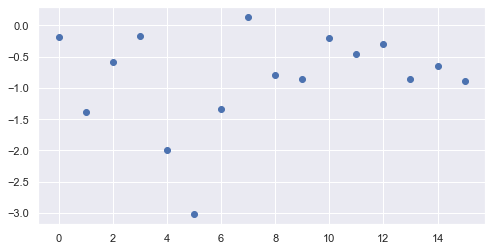

In [37]:
plt.plot(mu[1:], marker = 'o', linestyle = "None")
plt.show()

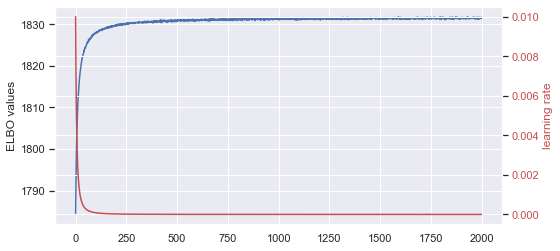

In [38]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(trace)
ax1.set_ylabel('ELBO values')

ax2 = ax1.twinx()
ax2.plot(1/(np.arange(len(trace))+10)**2, 'r-')
ax2.set_ylabel('learning rate', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

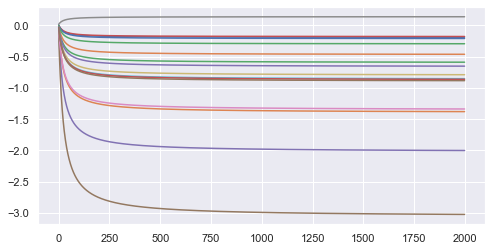

In [39]:
trace_mu = np.array(trace_mu)
plt.plot(trace_mu[:,1:,0])
plt.show()

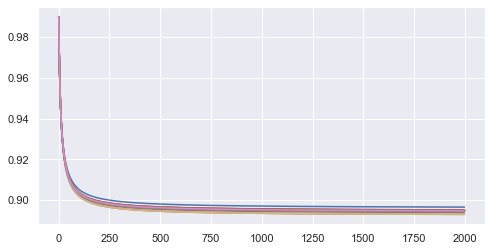

In [40]:
trace_L = np.array(trace_L)
for i in range(17):
    plt.plot(trace_L[:,i,i])
plt.show()

<a id="model2"></a>

## 2. Student noise and gaussian prior

- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$

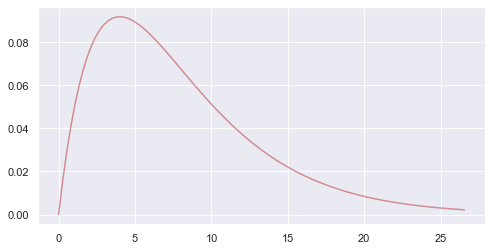

In [41]:
reset_plot()
a = 2
scale = 4
x = np.linspace(gamma.pdf(0.01, a, scale = scale),
                gamma.ppf(0.99, a, scale= scale), 100)
plt.plot(x, gamma.pdf(x, a, scale = scale),
       'r-', alpha=0.6, label='gamma pdf')
plt.show()

Compared to before, we have to change the likelihood

In [42]:
def log_prior_df(df):
    return np.log(gamma.pdf(df,a = 2, scale = 4))

In [43]:
def log_likelihood_student(Y,X,beta,df):
    return np.sum(np.log(student.pdf(Y-X@beta,df = df)))

In [44]:
def log_posterior_student(beta,df,Y,X):
    return log_likelihood_student(Y,X,beta,df)+log_prior_beta(beta)+log_prior_df(df)

def log_posterior_student_simple(theta):
    beta = theta[1:]
    df = theta[0]
    return log_posterior_student(beta,df,Y,X)

In [45]:
def loss_student(beta,df):
    return -log_posterior_student(beta,df,Y,X)

<a id="MH2"></a>
### Metropolis Hastings

Line search to determine the step size of the metropolis hastings algortihm

/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


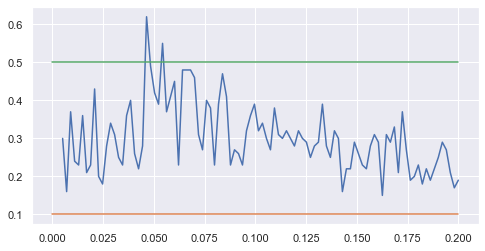

In [46]:
S = []
A = []
for s in np.linspace(0.005,0.2,100):
    samples, a = sampling.MH_sampling(log_posterior_student_simple,size = 17,max_iter= 100, step_size= s, acc = True, verbose=False, verbose_gen = False,student = (20,2))
    S.append(s)
    A.append(a)
plt.plot(np.array(S), np.array(A))
plt.plot([0,0.2],[0.1,0.1])
plt.plot([0,0.2],[0.5,0.5])
plt.show()

We decide to go with a step size of `0.06` for the $\beta_i$ and `2` for df

In [47]:
with warnings.catch_warnings(record=True):
    samples_student = sampling.MH_sampling(log_posterior_student_simple,size = 17,max_iter= 80000, step_size= 0.06, student = (20.,2))
np.save("results/samples_student_MH",samples_student)

Metropolis Hasting started at: 2019-05-28 15:26:22
Simulating data : [====================] 100.0%   Acceptance rate : 21.8%  (advised values between 10% and 50%)
  duration: 0:02:19


In [48]:
samples_student = np.load("results/samples_student_MH.npy")

iterations


/home/charles/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/charles/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/charles/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/charles/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/charles/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amou

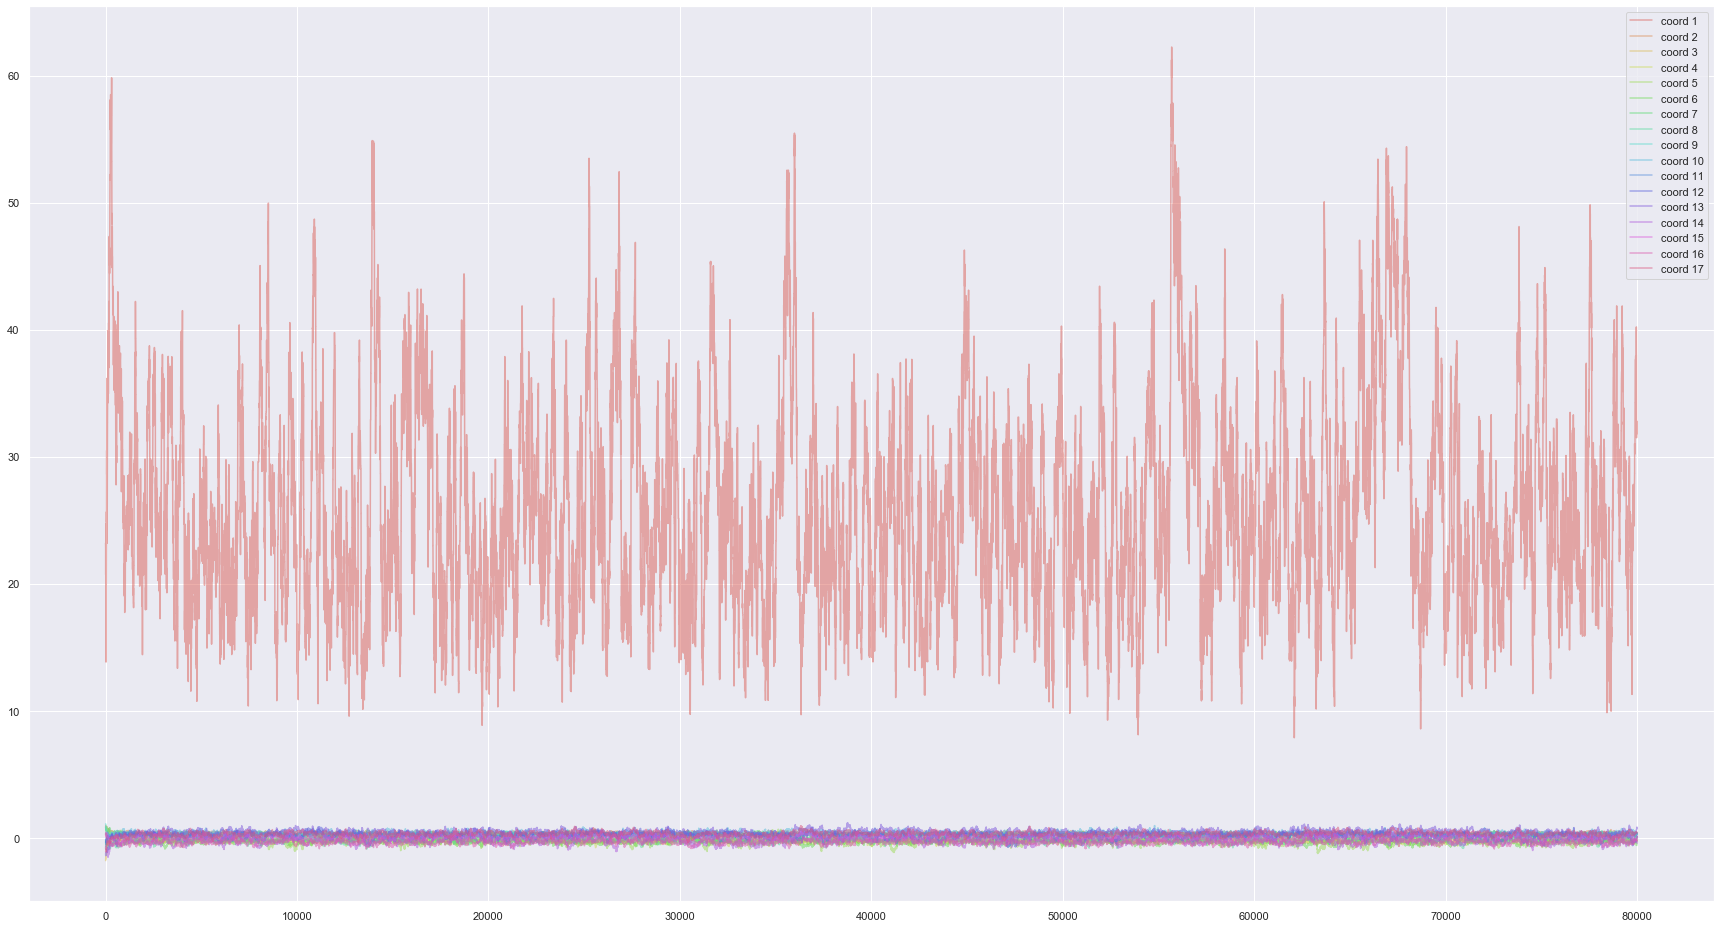

estimation of the distributions


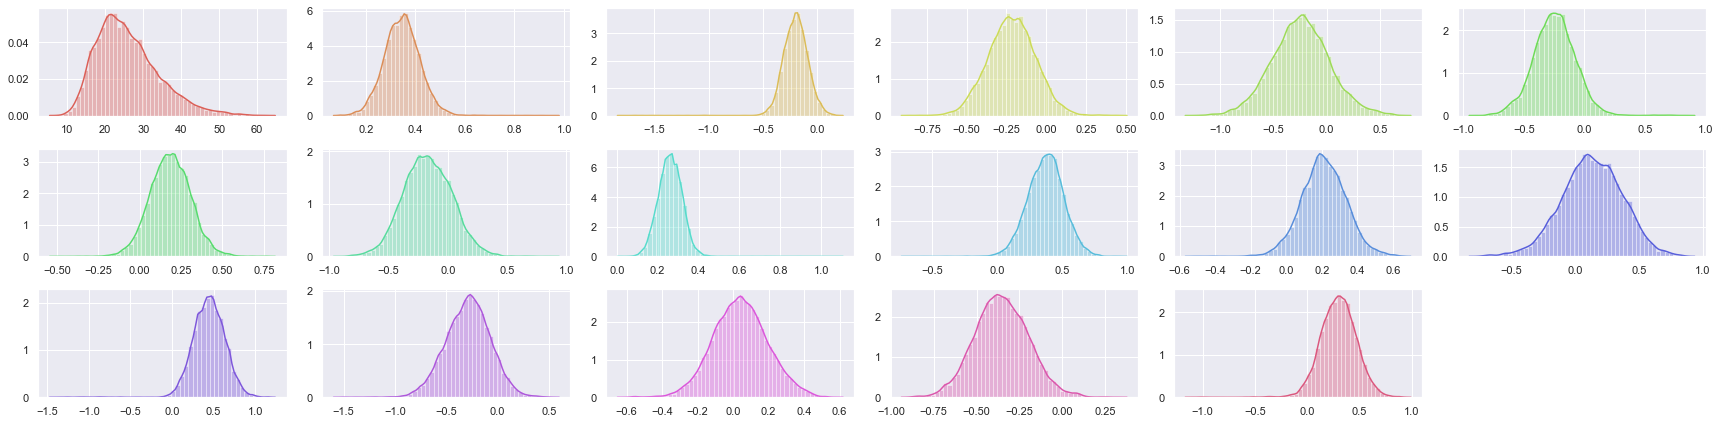

In [49]:
Plot.samples_exploration(samples_student, distribution = True, correlation = False)

<a id="IS2"></a>

### Importance sampling

In [50]:
# proposal will be a gaussian N(0,5)
def proposal_generation(n):
    return np.random.normal(0,5,(n,1+len(beta_OLS)))

def proposal(theta):
    return norm.pdf(theta,loc = 0, scale = 5)

def posterior_unormalized_student(beta):
    return np.exp(log_posterior_student_simple(beta))

samples,weight = np.array(sampling.importance_sampling(posterior_unormalized_student,proposal_generation,proposal,80000, separated= True))

/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
weighted_samples_student = samples*weight
np.save("results/weighted_samples_student",weighted_samples_student)

### Comparison 

In [ ]:
samples_student = np.load("results/samples_student_MH.npy")
weighted_samples_student = np.load("results/weighted_samples_student.npy")

In [ ]:
big_plot()
plt.errorbar(np.arange(len(weighted_samples_student[0])), np.mean(weighted_samples_student,axis=0), np.std(weighted_samples_student,axis = 0), linestyle='None',marker = "o", capsize=5, label = "imporance sampling") 
plt.errorbar(np.arange(len(samples_student[0])), np.mean(samples_student,axis=0), np.std(samples_student,axis = 0), linestyle='None',marker = "o", capsize=5, label = "MH") 
plt.xticks(np.arange(0,18,1),np.arange(0,18,1))
plt.ylim(-1,1)
plt.legend()
plt.title("mean estimation and std")
plt.show()
reset_plot()


<a id="GVA2"></a>

### GVA

<a id="model3"></a>

## 3. Sparse prior and gaussian noise

We will use the spike slab prior:

- conditional model:
$$Y \sim X\beta + \varepsilon \quad \quad \varepsilon \sim \mathcal{N}(0,\sigma_0^2) $$


- priors:
$$ \sigma_0^2 \sim exp(\lambda = 2)$$

$$\beta_i | F_i\sim F_i\mathcal{N}(0,\sigma^2) + (1-F_i)\delta(\beta_i) \quad \quad F_i \sim B\left(\frac{1}{dim(\beta)}\right),\sigma = 1$$


In [ ]:
def log_prior_sigma(sigma):
    return np.log(expon.pdf(sigma, scale = 1/2))

In [ ]:
def log_prior_sparse(F,beta,sigma):
    
    if len(F) != len(beta):
        print("F and beta should have same size but have sizes {} and {}".format(len(F),len(beta)))
        return ValueError
    
    p = 1./len(beta)
    
    log_prior_F = np.sum(np.log(bernoulli.pmf(F,p = p)))
    log_prior_beta = np.sum(np.log(norm.pdf(beta[F==1]) +len(beta[(beta == 0)&(F==0)])))
    
    return log_prior_F + log_prior_beta + log_prior_sigma(sigma)                     

In [ ]:
def log_likelihood_sparse(y,x,beta,F,sigma):
    result = 0
    for x,y in zip(X,Y):
        result += np.log(F*norm.pdf((y-x.T@beta)/sigma)+len(beta[(beta == 0)&(F==0)]))
    return result - len(Y)*np.log(sigma)

In [ ]:
def log_posterior_sparse(y,x,beta,F,sigma):
    return log_likelihood_sparse(y,x,beta,F,sigma)+log_prior_sparse(F,beta,sigma)

<a id="MH3"></a>
### Metropolis Hastings within Gibbs

<a id="IS3"></a>
### Importance sampling

<a id="GVA3"></a>
### GVA

<a id="classification"></a>

## Classification

In [ ]:
inter = df.LNWAGE.values.astype(int)
classes = inter.copy()
classes[df.LNWAGE >= 1] = 1
classes[df.LNWAGE < 1 ]= 2
classes[df.LNWAGE < 0] = 3
classes[df.LNWAGE < -1] = 4

In [ ]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
def convert(n): 
    return flatui[n]
colors = list(map(convert, classes) )
plt.scatter(df.index,df.LNWAGE, c = colors)
plt.show()